In [1]:
import tensorflow as tf
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import PIL

%matplotlib inline

In [2]:
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

In [3]:
shape = 100, 100
num_channels = 1
vec_size = 64

## Data utils

In [31]:
def load_dir(path, shape=[400, 400]):
    data = []
    for i in os.listdir(path):
        try:
            img = np.array(Image.open(os.path.join(path, i)).resize(shape))
            if len(img.shape) != 3:
                img = np.stack((img,)*3, -1)
            if img.shape[-1] != 3:
                continue
            data.append(img)
        except:
            1
    return np.array(data)

def load_dirs(path, shape=[400, 400]):
    data = []

    for dir in os.listdir(path):
        if os.path.isdir(os.path.join(path, dir)):
            data.extend(load_dir(os.path.join(path, dir)))

    data = np.array(data)
    
    return data

data = []
root_dir = 'notMNIST_small/'

for dir in os.listdir(root_dir):
    if os.path.isdir(os.path.join(root_dir, dir)):
        data.extend(load_dir(os.path.join(root_dir, dir), shape=shape))
    
data = np.array(data)
data = np.array(list(map(lambda x: x[:, :, 0], data)))

In [32]:
data = data.reshape([-1, shape[0], shape[1], 1])

In [33]:
data.shape

(18724, 100, 100, 1)

## VAE

In [6]:
x = tf.placeholder(dtype=tf.float32, shape=[None, shape[0], shape[1], num_channels])

### Encoder

In [7]:
def encoder(x):
    # Convolutions 

    conv = tf.layers.conv2d(x, 16, 4, activation=tf.nn.relu)
    pool = tf.layers.max_pooling2d(conv, 6, 1)

    conv = tf.layers.conv2d(pool, 32, 4, activation=tf.nn.relu)
    pool = tf.layers.max_pooling2d(conv, 8, 2)

    # Denses

    pool_shape = pool.shape

    flat_pool = tf.reshape(pool, [-1, (pool_shape[1]*pool_shape[2]*pool_shape[3]).value])

    dense = tf.layers.dense(flat_pool, 256, activation=tf.nn.relu)

    # Output

    gausian_params = tf.layers.dense(dense, vec_size*2)

    return gausian_params[:, :vec_size], 1e-16 + tf.nn.softplus(gausian_params[:, vec_size:])

In [8]:
with tf.variable_scope('encoder'):
    means, std_devs = encoder(x)

z = means + std_devs * tf.random_uniform(tf.shape(means), 0, 1, dtype=tf.float32)

## Decoder

In [9]:
input_z = tf.placeholder(tf.float32, shape=[None, vec_size])

In [10]:
decoder_weights = {
    'first_dense': tf.Variable(glorot_init(shape=[vec_size, 64]), dtype=tf.float32, name='first_dense'),
    'second_dense': tf.Variable(glorot_init(shape=[64, 128]), dtype=tf.float32, name='second_dense'),
    'third_dense': tf.Variable(glorot_init(shape=[128, 256]), dtype=tf.float32, name='third_dense'),
    'output': tf.Variable(glorot_init(shape=[128, shape[0]*shape[1]*num_channels]), dtype=tf.float32, name='output'),
}

decoder_biases = {
    'first_dense': tf.Variable(tf.zeros(64), dtype=tf.float32, name='first_dense'),
    'second_dense': tf.Variable(tf.zeros(128), dtype=tf.float32, name='second_dense'),
    'third_dense': tf.Variable(tf.zeros(128), dtype=tf.float32, name='third_dense'),
    'output': tf.Variable(tf.zeros(shape[0]*shape[1]*num_channels), name='output')
}

In [11]:
def decoder(z):
    
    dense = tf.nn.relu(tf.matmul(z, decoder_weights['first_dense']) + decoder_biases['first_dense'])
    
    dense = tf.nn.relu(tf.matmul(dense, decoder_weights['second_dense']) + decoder_biases['second_dense'])
        
    raw_output = tf.matmul(dense, decoder_weights['output']) + decoder_biases['output']
    
    raw_output = tf.clip_by_value(raw_output, 0, 255)
    
    return tf.reshape(raw_output, shape=[tf.shape(raw_output)[0], shape[0], shape[1], num_channels])

In [12]:
y = decoder(z)
output_decoder = decoder(input_z)

## Train Utils

In [13]:
marginal_likelihood = tf.reduce_sum(np.power(x - y, 2))
KL_divergence = 0.5 * tf.reduce_sum(tf.square(means) + tf.square(std_devs) - tf.log(1e-8 + tf.square(std_devs)) - 1, 1)

marginal_likelihood = tf.reduce_mean(marginal_likelihood)
KL_divergence = tf.reduce_mean(KL_divergence)

loss = marginal_likelihood + KL_divergence

In [14]:
optim = tf.train.AdamOptimizer().minimize(loss)

## Training

In [15]:
sess = tf.InteractiveSession()

In [16]:
sess.run(tf.global_variables_initializer())

In [17]:
save = tf.train.Saver()

In [17]:
save.restore(sess, 'new_weights/VAE_notMNIST_25')

In [57]:
def display_encoded(ids, one_channel=True):
    shape = data.shape[1],data.shape[2]
    
    f, axar = plt.subplots(len(ids), 2, figsize=(8, 6))
    
    for e, i in enumerate(ids):
        axar[e, 0].grid(False); axar[e, 1].grid(False)
        
        if one_channel:
            pic = data[i].reshape(shape)
        else:
            pic = data[i]
            
        axar[e, 0].imshow(PIL.Image.fromarray(pic), cmap='Greys',)
        generated = sess.run(y, feed_dict={x: np.array([data[i]], dtype=np.float32)})
        
        if one_channel:
            gen_pic = generated[0].astype(np.uint8).reshape(shape)
        else:
            gen_pic = generated[0].astype(np.uint8)
            
        axar[e, 1].imshow(PIL.Image.fromarray(gen_pic), cmap='Greys')

In [110]:
batchsize = 100
epochs = 500

for e in range(epochs):
    np.random.shuffle(data)
    print('Epoch: ', e)
    losses = []
    for i in range(0, len(data)-batchsize, batchsize):
        _, l = sess.run([optim, loss], feed_dict={x: data[i:i+batchsize]})
        losses.append(l)
        if i % 100 == 0:
            print('Loss: ', np.mean(losses))
            
    save.save(sess, 'new_weights/VAE_notMNIST_BW_'+str(e))
    print('Epoch loss: ', np.mean(losses))

Epoch:  0
Loss:  2.97126e+09
Loss:  3.00307e+09
Loss:  3.01737e+09
Loss:  3.06627e+09
Loss:  3.04415e+09
Loss:  3.05622e+09
Loss:  3.02202e+09
Loss:  3.00984e+09
Loss:  3.01152e+09
Loss:  3.00416e+09
Loss:  3.01494e+09
Loss:  2.99681e+09
Loss:  3.01104e+09
Loss:  3.0025e+09
Loss:  3.00564e+09
Loss:  2.99537e+09
Loss:  3.0027e+09
Loss:  2.99762e+09
Loss:  3.00128e+09
Loss:  3.00463e+09
Loss:  3.00784e+09
Loss:  3.00821e+09
Loss:  3.003e+09
Loss:  3.00254e+09
Loss:  3.00887e+09
Loss:  3.01507e+09
Loss:  3.00988e+09
Loss:  3.01412e+09
Loss:  3.0102e+09
Loss:  3.00769e+09
Loss:  3.00465e+09
Loss:  3.00264e+09
Loss:  2.99919e+09
Loss:  2.99058e+09
Loss:  2.99453e+09
Loss:  2.99141e+09
Loss:  2.99197e+09
Loss:  2.98778e+09
Loss:  2.98622e+09
Loss:  2.99144e+09
Loss:  2.99317e+09
Loss:  2.9941e+09
Loss:  2.99428e+09
Loss:  2.99287e+09
Loss:  2.99313e+09
Loss:  2.99254e+09
Loss:  2.9941e+09
Loss:  2.99459e+09
Loss:  2.9974e+09
Loss:  2.99746e+09
Loss:  2.99797e+09
Loss:  2.99684e+09
Loss:  2.9

KeyboardInterrupt: 

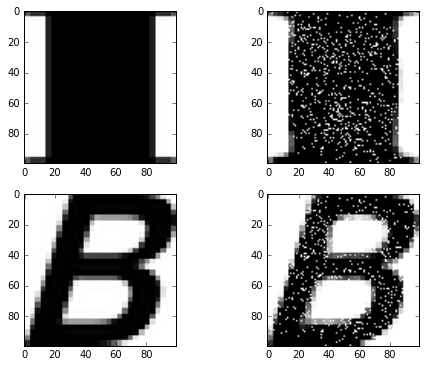

In [115]:
display_encoded([14234, 12324])